In [104]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import os
import pickle5 as pickle
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [105]:
def load_data(file_name):
    assert(os.path.exists(file_name+'.pkl'))
    with open(file_name + '.pkl', 'rb') as f:
        data = pickle.load(f)
    return data

In [106]:
def save_data(data, file_path):
    with open(file_path + '.pkl','wb') as f:
        pickle.dump(data,f,pickle.HIGHEST_PROTOCOL)

#### The synthetic data is generated inside the "generate_synthetic.py" script. Please refer to section 5 of the [paper](https://arxiv.org/pdf/2103.08902.pdf) for more details on synthetic experiments.

In [107]:
data_path = 'synthetic'
model_dir = 'models/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

#### we consider the hypothesis class of predictive models M(Θ) parameterized by sigmoid functions.

In [108]:
class RegNet(torch.nn.Module):
    def __init__(self, input_dim,output_dim):
        super(RegNet, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = torch.sigmoid(self.linear(x))
        return x

### No Automation Without Triage (figure 1a left)

#### the machine model is trained on all the datapoints and no point is outsourced.

In [109]:
def train_full(data_path):
    machine_type = 'full'
    print('training machine model: ',machine_type)
    data = load_data(data_path)
    clusters = data['clusters']
    X = torch.cat([cluster['x'] for cluster in clusters]).to(device)
    Y = torch.cat([cluster['y'] for cluster in clusters]).to(device)
    hloss = torch.cat([cluster['hloss'] for cluster in clusters]).to(device)
    
    num_epochs = 15
    
    mnet = RegNet(1, 1).to(device)
    optimizer = torch.optim.Adam(mnet.parameters(), lr=0.15)
    loss_func = torch.nn.MSELoss(reduction='none')
    train_losses = []
    
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        optimizer.zero_grad()
        loss = loss_func(mnet(X),Y)
        loss.sum().backward()
        optimizer.step()
        train_loss = float(loss.mean())
        train_losses.append(train_loss)
        print('machine_loss:', train_loss)
        print('\n')
        
    
    torch.save(mnet.state_dict(), model_dir + 'm_' + machine_type)
    
    #training is finished, we plot the results:
    c = [i/4 for i in range(X.shape[0])]
    machine_loss = loss_func(mnet(X),Y).cpu().data.numpy()
    plt.scatter(hloss.cpu().data.numpy(),machine_loss,alpha=0.3,c=c)
    line = torch.unsqueeze(torch.linspace(-0.01, 0.06, 100), dim=1)
    plt.plot(line,line)
    plt.xlabel('Human Loss',fontsize=18)
    plt.ylabel('Machine Loss',fontsize=18)
    plt.show()
        
    plt.scatter(X.cpu().data.numpy(),Y.cpu().data.numpy(),alpha=0.3,c=c)
    line = torch.unsqueeze(torch.linspace(-3, 3, 1000), dim=1).to(device)
    plt.plot(line.cpu().data.numpy(), mnet(line).cpu().data.numpy(),label='machine_decision')
    machine_loss = np.mean(machine_loss)
    plt.text(1.2,0.8,'total loss: ' + str(machine_loss)[:6],fontsize=18)
    plt.xlabel(r'Feature x',fontsize=18)
    plt.ylabel(r'Response y',fontsize=18)
    plt.show()
    
    plt.plot(range(len(train_losses)),train_losses,marker='o',label='train')
    plt.legend()
    plt.xlabel(r'Time Step t',fontsize=18)
    plt.ylabel(r'Machine Loss',fontsize=18)
    plt.show()

training machine model:  full
----- epoch: 0 -----
machine_loss: 0.41751042008399963


----- epoch: 1 -----
machine_loss: 0.36745062470436096


----- epoch: 2 -----
machine_loss: 0.3108590841293335


----- epoch: 3 -----
machine_loss: 0.2502073347568512


----- epoch: 4 -----
machine_loss: 0.19042985141277313


----- epoch: 5 -----
machine_loss: 0.1379612237215042


----- epoch: 6 -----
machine_loss: 0.0975915715098381


----- epoch: 7 -----
machine_loss: 0.06966010481119156


----- epoch: 8 -----
machine_loss: 0.05100010707974434


----- epoch: 9 -----
machine_loss: 0.038188908249139786


----- epoch: 10 -----
machine_loss: 0.029077503830194473


----- epoch: 11 -----
machine_loss: 0.022490130737423897


----- epoch: 12 -----
machine_loss: 0.01771952025592327


----- epoch: 13 -----
machine_loss: 0.014281709678471088


----- epoch: 14 -----
machine_loss: 0.011823643930256367




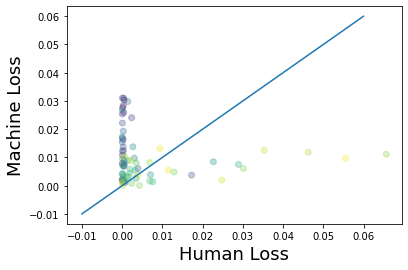

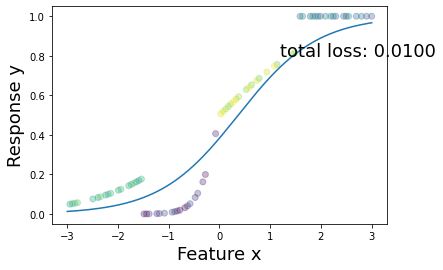

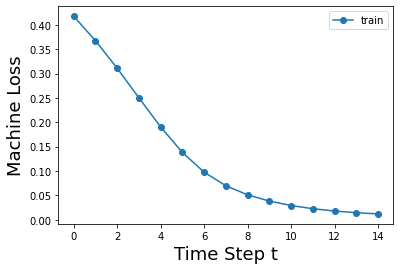

In [110]:
train_full(data_path)

### No Automation with Triage (figure 1a right)

#### The machine model is trained on all the datapoints but in the end the machine only decides about those points which are assigned to it based on the optimal triage policy for the machine model.

In [127]:
def train_full_with_triage(data_path):
    machine_type = 'full_triage'
    print('training machine model: ',machine_type)
    data = load_data(data_path)
    clusters = data['clusters']
    X = torch.cat([cluster['x'] for cluster in clusters]).to(device)
    Y = torch.cat([cluster['y'] for cluster in clusters]).to(device)
    hloss = torch.cat([cluster['hloss'] for cluster in clusters]).to(device)
    
    num_epochs = 15
    
    mnet = RegNet(1, 1).to(device)
    optimizer = torch.optim.Adam(mnet.parameters(), lr=0.15)
    loss_func = torch.nn.MSELoss(reduction='none')
    train_losses = []
    
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        optimizer.zero_grad()
        loss = loss_func(mnet(X),Y)
        loss.sum().backward()
        optimizer.step()
        train_loss = float(loss.mean())
        train_losses.append(train_loss)
        print('machine_loss:', train_loss)
        print('\n')
        
        
    torch.save(mnet.state_dict(), model_dir + 'm_' + machine_type)
    #training is finished, we plot the results:    
    with torch.no_grad():
        c = [i/4 for i in range(X.shape[0])]
        machine_loss = loss_func(mnet(X),Y)
        machine_indices = find_machine_samples(machine_loss,hloss,constraint = 1.0).cpu()
        machine_loss = machine_loss.cpu().data.numpy()
        human_indices = [i for i in range(X.shape[0]) if i not in machine_indices]
        c_machine = [i/4 for i in machine_indices]
        c_human = [i/4 for i in human_indices]

        plt.scatter(hloss.cpu().data.numpy(),machine_loss,alpha=0.3,c=c)
        line = torch.unsqueeze(torch.linspace(-0.01, 0.1, 1000), dim=1)
        plt.plot(line,line)
        plt.xlabel('Human Loss',fontsize=18)
        plt.ylabel('Machine Loss',fontsize=18)
        plt.show()

        plt.scatter(X[machine_indices].cpu().data.numpy(),Y[machine_indices].cpu().data.numpy(),c = c_machine,alpha=0.3)
        plt.scatter(X[human_indices].cpu().data.numpy(),Y[human_indices].cpu().data.numpy(),c = c_human)
        line = torch.unsqueeze(torch.linspace(-3, 3, 1000), dim=1).to(device)
        plt.plot(line.cpu().data.numpy(), mnet(line).cpu().data.numpy(),label='machine_decision')
        machine_loss = np.sum(loss.cpu().data.numpy())
        human_loss = np.sum(hloss[human_indices].cpu().data.numpy())
        plt.text(1.2,0.8,'total loss: ' + str(((machine_loss + human_loss)/X.shape[0]))[:6],fontsize=18)
        plt.xlabel(r'Feature x',fontsize=18)
        plt.ylabel(r'Response y',fontsize=18)
        plt.show()

        torch.save(mnet.state_dict(), model_dir + 'm_' + machine_type)
        plt.plot(range(len(train_losses)),train_losses,marker='o',label='train')
        plt.legend()
        plt.xlabel(r'Time Step t',fontsize=18)
        plt.ylabel(r'Machine Loss',fontsize=18)
        plt.show()

training machine model:  full_triage
----- epoch: 0 -----
machine_loss: 0.06397513300180435


----- epoch: 1 -----
machine_loss: 0.04299324005842209


----- epoch: 2 -----
machine_loss: 0.029122687876224518


----- epoch: 3 -----
machine_loss: 0.02014552615582943


----- epoch: 4 -----
machine_loss: 0.014394973404705524


----- epoch: 5 -----
machine_loss: 0.01076432503759861


----- epoch: 6 -----
machine_loss: 0.008539079688489437


----- epoch: 7 -----
machine_loss: 0.007250215392559767


----- epoch: 8 -----
machine_loss: 0.006580730434507132


----- epoch: 9 -----
machine_loss: 0.006311147473752499


----- epoch: 10 -----
machine_loss: 0.006287707481533289


----- epoch: 11 -----
machine_loss: 0.006402908358722925


----- epoch: 12 -----
machine_loss: 0.006582787726074457


----- epoch: 13 -----
machine_loss: 0.006778037175536156


----- epoch: 14 -----
machine_loss: 0.006957503035664558




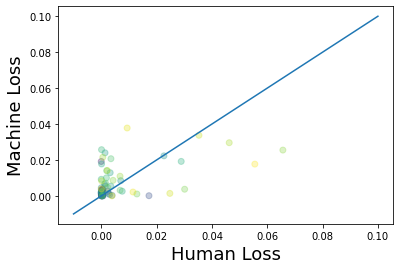

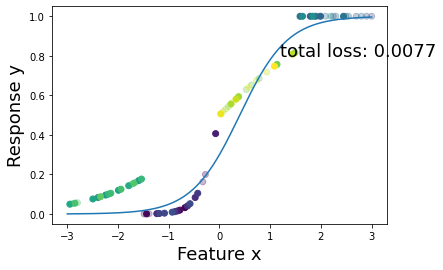

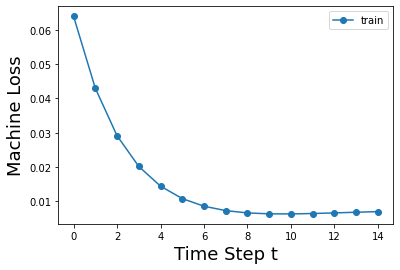

In [128]:
train_full_with_triage(data_path)

### Learning Under Triage without using the optimal triage policy (figure 1b left)

#### The machine model is trained under triage and only on the points which are assigned to machine based on the optimal triage policy. In the end, we show that if the optimal triage policy is not used, we will incure more loss than when we use the optimal triage policy (figure 1b left vs right)

In [113]:
def find_machine_samples(machine_loss, hloss,constraint):
    
    diff = (machine_loss - hloss).squeeze()
    argsorted_diff = torch.clone(torch.argsort(diff))
    num_outsource = int(constraint * machine_loss.shape[0])
    index = -num_outsource

    while (index < -1 and diff[argsorted_diff[index]] <= 0):
        index += 1

    machine_list = argsorted_diff[:index]

    return machine_list

In [125]:
def train_triage_not_opt(data_path):
    machine_type = 'Differentiable_not_opt'
    print('training machine model using: ',machine_type)
    data = load_data(data_path)
    clusters = data['clusters']
    X = torch.cat([cluster['x'] for cluster in clusters]).to(device)
    Y = torch.cat([cluster['y'] for cluster in clusters]).to(device)
    hloss = torch.cat([cluster['hloss'] for cluster in clusters]).to(device)
    
    num_epochs = 15
    
    mnet = RegNet(1, 1).to(device)
    optimizer = torch.optim.Adam(mnet.parameters(), lr=0.15)
    loss_func = torch.nn.MSELoss(reduction='none')
    train_losses = []
    
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        with torch.no_grad():
            mprim = copy.deepcopy(mnet)
            machine_scores = mprim(X)
            machine_loss = loss_func(machine_scores,Y)
        machine_indices = find_machine_samples(machine_loss, hloss, constraint=1.0)


        X_machine = X[machine_indices]
        Y_machine = Y[machine_indices]
        optimizer.zero_grad()
        loss = loss_func(mnet(X_machine),Y_machine)
        
        loss.sum().backward()
        optimizer.step()
        train_loss = float(loss.mean())
        train_losses.append(train_loss)
        print('machine_loss:', train_loss)
        print('\n')
        
        
    torch.save(mnet.state_dict(), model_dir + 'm_' + machine_type)
    
    #training is finished, we plot the results:
    full_mnet = RegNet(1,1).to(device)
    full_mnet.load_state_dict(torch.load(model_dir + 'm_full'))
    full_mnet.eval()
    c = [i/4 for i in range(X.shape[0])]
    machine_loss = loss_func(full_mnet(X),Y)
    machine_indices = find_machine_samples(machine_loss,hloss,constraint = 1.0).cpu()
    machine_loss = machine_loss.cpu().data.numpy()
    human_indices = [i for i in range(X.shape[0]) if i not in machine_indices]
    c_machine = [i/4 for i in machine_indices]
    c_human = [i/4 for i in human_indices]
    machine_loss = loss_func(mnet(X),Y).cpu().data.numpy()
    plt.scatter(hloss.cpu().data.numpy(),machine_loss,alpha=0.3,c=c)
    line = torch.unsqueeze(torch.linspace(-0.01, 0.1, 1000), dim=1)
    plt.plot(line,line)
    plt.xlabel('Human Loss',fontsize=18)
    plt.ylabel('Machine Loss',fontsize=18)
    plt.show()
    
    
    plt.scatter(X[machine_indices].cpu().data.numpy(),Y[machine_indices].cpu().data.numpy(),c = c_machine,alpha=0.3)
    plt.scatter(X[human_indices].cpu().data.numpy(),Y[human_indices].cpu().data.numpy(),c = c_human)
    line = torch.unsqueeze(torch.linspace(-3, 3, 1000), dim=1).to(device)
    plt.plot(line.cpu().data.numpy(), mnet(line).cpu().data.numpy(),label='machine_decision')
    machine_loss = np.sum(loss.cpu().data.numpy())
    human_loss = np.sum(hloss[human_indices].cpu().data.numpy())
    plt.text(1.2,0.8,'total loss: ' + str(((machine_loss + human_loss)/X.shape[0]))[:6],fontsize=18)
    plt.xlabel(r'Feature x',fontsize=18)
    plt.ylabel(r'Response y',fontsize=18)
    plt.show()
    
    
    plt.plot(range(len(train_losses)),train_losses,marker='o',label='train')
    plt.legend()
    plt.title(machine_type ,fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.show()


training machine model using:  Differentiable_not_opt
----- epoch: 0 -----
machine_loss: 0.002759828232228756


----- epoch: 1 -----
machine_loss: 0.00184587889816612


----- epoch: 2 -----
machine_loss: 0.00040166868711821735


----- epoch: 3 -----
machine_loss: 0.00026887503918260336


----- epoch: 4 -----
machine_loss: 0.0008382655214518309


----- epoch: 5 -----
machine_loss: 0.0010880889603868127


----- epoch: 6 -----
machine_loss: 0.0010953857563436031


----- epoch: 7 -----
machine_loss: 0.0010448896791785955


----- epoch: 8 -----
machine_loss: 0.0009108678204938769


----- epoch: 9 -----
machine_loss: 0.0007681543938815594


----- epoch: 10 -----
machine_loss: 0.0005120049463585019


----- epoch: 11 -----
machine_loss: 0.00028292849310673773


----- epoch: 12 -----
machine_loss: 0.00020345146185718477


----- epoch: 13 -----
machine_loss: 0.00028890237445011735


----- epoch: 14 -----
machine_loss: 0.00042440605466254056




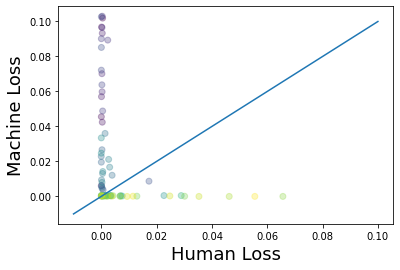

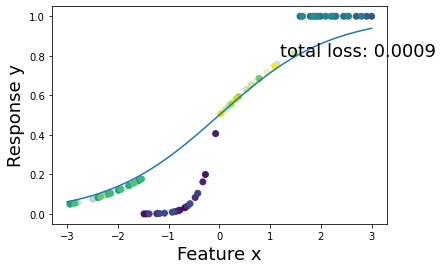

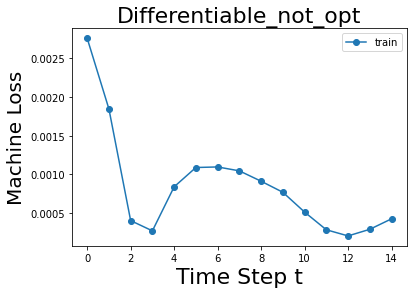

In [126]:
train_triage_not_opt(data_path)

### Our Method : Learning under triage: training the machine on only machine points which are found using the optimal triage policy (figure 1b right).

In [116]:
def find_machine_samples(machine_loss, hloss,constraint):
    
    diff = (machine_loss - hloss).squeeze()
    argsorted_diff = torch.clone(torch.argsort(diff))
    num_outsource = int(constraint * machine_loss.shape[0])
    index = -num_outsource

    while (index < -1 and diff[argsorted_diff[index]] <= 0):
        index += 1

    machine_list = argsorted_diff[:index]

    return machine_list

In [117]:
def train_triage(data_path):
    machine_type = 'Differentiable'
    print('training machine model: ',machine_type)
    data = load_data(data_path)
    clusters = data['clusters']
    X = torch.cat([cluster['x'] for cluster in clusters]).to(device)
    Y = torch.cat([cluster['y'] for cluster in clusters]).to(device)
    hloss = torch.cat([cluster['hloss'] for cluster in clusters]).to(device)
    
    num_epochs = 15
    
    mnet = RegNet(1, 1).to(device)
    optimizer = torch.optim.Adam(mnet.parameters(), lr=0.15)
    loss_func = torch.nn.MSELoss(reduction='none')
    train_losses = []
    
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        with torch.no_grad():
            mprim = copy.deepcopy(mnet)
            machine_scores = mprim(X)
            machine_loss = loss_func(machine_scores,Y)
            
        machine_indices = find_machine_samples(machine_loss, hloss, constraint=1.0)
        X_machine = X[machine_indices]
        Y_machine = Y[machine_indices]
        optimizer.zero_grad()
        loss = loss_func(mnet(X_machine),Y_machine)
        
        loss.sum().backward()
        optimizer.step()
        train_loss = float(loss.mean())
        train_losses.append(train_loss)
        print('machine_loss:', train_loss)
        print('\n')
    
    torch.save(mnet.state_dict(), model_dir + 'm_' + machine_type + str(constraint))
    
    #training is finished, we plot the results:
    machine_indices = machine_indices.cpu()
    human_indices = [i for i in range(X.shape[0]) if i not in machine_indices]
    c_machine = [i/4 for i in machine_indices]
    c_human = [i/4 for i in human_indices]
    c = [i/4 for i in range(X.shape[0])]
    machine_loss = loss_func(mnet(X),Y).cpu().data.numpy()
    plt.scatter(hloss.cpu().data.numpy(),machine_loss,alpha=0.3,c=c)
    line = torch.unsqueeze(torch.linspace(-0.01, 0.1, 1000), dim=1)
    plt.plot(line,line)
    plt.xlabel('Human Loss',fontsize=18)
    plt.ylabel('Machine Loss',fontsize=18)
    plt.show()
    
    plt.scatter(X[machine_indices].cpu().data.numpy(),Y[machine_indices].cpu().data.numpy(),c = c_machine,alpha=0.3)
    plt.scatter(X[human_indices].cpu().data.numpy(),Y[human_indices].cpu().data.numpy(),c = c_human)
    line = torch.unsqueeze(torch.linspace(-3, 3, 1000), dim=1).to(device)
    plt.plot(line.cpu().data.numpy(), mnet(line).cpu().data.numpy(),label='machine_decision')
    machine_loss = np.sum(loss.cpu().data.numpy())
    human_loss = np.sum(hloss[human_indices].cpu().data.numpy())
    plt.text(1.2,0.8,'total loss: ' + str(((machine_loss + human_loss)/X.shape[0]))[:6],fontsize=18)
    plt.xlabel(r'Feature x',fontsize=18)
    plt.ylabel(r'Response y',fontsize=18)
    plt.show()
    
    
    plt.plot(range(len(train_losses)),train_losses,marker='o',label='train')
    plt.legend()
    plt.title(machine_type + ' b = ' + str(constraint),fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.show()


training machine model using constraint: 1.0  and machine model:  Differentiable
----- epoch: 0 -----
machine_loss: 0.02485334686934948


----- epoch: 1 -----
machine_loss: 0.01862131431698799


----- epoch: 2 -----
machine_loss: 0.008859141729772091


----- epoch: 3 -----
machine_loss: 0.003638911060988903


----- epoch: 4 -----
machine_loss: 0.0021801141556352377


----- epoch: 5 -----
machine_loss: 0.0025245393626391888


----- epoch: 6 -----
machine_loss: 0.004256853833794594


----- epoch: 7 -----
machine_loss: 0.005557036958634853


----- epoch: 8 -----
machine_loss: 0.004761021584272385


----- epoch: 9 -----
machine_loss: 0.0028044688515365124


----- epoch: 10 -----
machine_loss: 0.0032478359062224627


----- epoch: 11 -----
machine_loss: 0.0026259631849825382


----- epoch: 12 -----
machine_loss: 0.002408832311630249


----- epoch: 13 -----
machine_loss: 0.0012102448381483555


----- epoch: 14 -----
machine_loss: 0.0007031125132925808




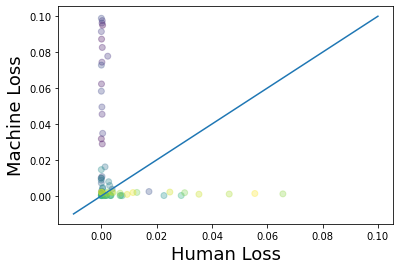

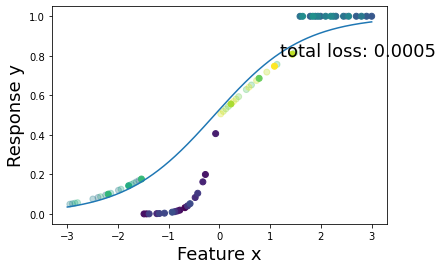

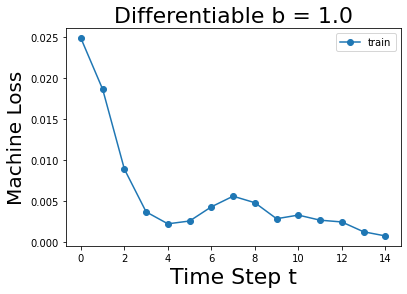

In [118]:
train_triage(data_path,constraint=1.0)